In [5]:
from fetch_data import fetch_events, clear_events, load_csv_and_create_dataframe, load_credentials
import numpy as np
import json
import pandas as pd
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Flatten
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error
plt.style.use('dark_background')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18008763392938911193
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11257714595374316404
physical_device_desc: "device: XLA_CPU device"
]


In [10]:
def fetch_multiple_days (credentials, *days):
    
    purchases, regular_events = clear_events(fetch_events(credentials['user'], credentials['pwd'], days[0]).json()[0])
    
    data = load_csv_and_create_dataframe(purchases, 1)
    data = load_csv_and_create_dataframe(regular_events, 0, data)
        
    for day in days[1:]:
        print (day)
        purchases, regular_events = clear_events(fetch_events(credentials['user'], credentials['pwd'], day).json()[0])
        data = load_csv_and_create_dataframe(purchases, 1, data)
        data = load_csv_and_create_dataframe(regular_events, 0, data)
        
    return data

## Fetching train and test data

In [ ]:
load_credentials()
credentials = {}
with open('credentials_visio.json') as creds:
    credentials = json.load(creds)
train_data = fetch_multiple_days(credentials, '2020-01-27', '2020-01-25', '2020-01-24', '2020-01-13', '2020-01-20')
test_data = fetch_multiple_days(credentials, '2020-01-14')

Login succed
Empty DataFrame
Columns: [id, day, pos, purchase]
Index: []
                id         day  \
0   1580134800_046  2020-01-27   
1   1580134800_063  2020-01-27   
2   1580161200_001  2020-01-27   
3   1580161200_004  2020-01-27   
4   1580161200_033  2020-01-27   
..             ...         ...   
73  1580169600_098  2020-01-27   
74  1580170800_027  2020-01-27   
75  1580170800_029  2020-01-27   
76  1580170800_053  2020-01-27   
77  1580170800_070  2020-01-27   

                                                  pos purchase  
0   [(127.0, 455.0, 192.0, 216.0), (128.0, 450.0, ...        1  
1   [(171.5, 429.0, 135.0, 250.0), (161.0, 436.0, ...        1  
2   [(99.0, 476.0, 200.0, 192.0), (99.0, 476.0, 20...        1  
3   [(131.0, 453.0, 180.0, 216.0), (132.0, 449.0, ...        1  
4   [(32.0, 457.0, 240.0, 192.0), (34.0, 452.0, 24...        1  
..                                                ...      ...  
73  [(144.0, 466.0, 180.0, 216.0), (135.0, 463.0, ...        1 

Blob 2020-01-25/1579993200_068.csv downloaded to data/1579993200_068.csv.
subway-iguatemi-saocarlos-balcao-logic
Blob 2020-01-25/1579993200_119.csv downloaded to data/1579993200_119.csv.
subway-iguatemi-saocarlos-balcao-logic
Blob 2020-01-25/1579993200_120.csv downloaded to data/1579993200_120.csv.
subway-iguatemi-saocarlos-balcao-logic
Blob 2020-01-25/1579996800_003.csv downloaded to data/1579996800_003.csv.
subway-iguatemi-saocarlos-balcao-logic
Blob 2020-01-25/1579996800_077.csv downloaded to data/1579996800_077.csv.
subway-iguatemi-saocarlos-balcao-logic
Blob 2020-01-25/1579996800_107.csv downloaded to data/1579996800_107.csv.
subway-iguatemi-saocarlos-balcao-logic
Blob 2020-01-25/1579996800_108.csv downloaded to data/1579996800_108.csv.
subway-iguatemi-saocarlos-balcao-logic
Blob 2020-01-25/1579996800_115.csv downloaded to data/1579996800_115.csv.
subway-iguatemi-saocarlos-balcao-logic
Blob 2020-01-25/1579996800_150.csv downloaded to data/1579996800_150.csv.
subway-iguatemi-saocar

In [4]:
print (test_data)
print (train_data)

test_data.summay()

                 id         day  \
0    1579011600_042  2020-01-14   
1    1579011600_066  2020-01-14   
2    1579016400_037  2020-01-14   
3    1579016400_052  2020-01-14   
4    1579016400_104  2020-01-14   
..              ...         ...   
546  1579046400_112  2020-01-14   
547  1579046400_113  2020-01-14   
548  1579046400_117  2020-01-14   
549  1579046400_119  2020-01-14   
550  1579046400_120  2020-01-14   

                                                   pos purchase  
0    [(137.0, 464.0, 192.0, 200.0), (136.0, 464.0, ...        1  
1    [(130.0, 448.5, 192.0, 225.0), (130.0, 446.5, ...        1  
2    [(166.0, 464.0, 160.0, 200.0), (165.0, 463.0, ...        1  
3    [(185.5, 483.0, 135.0, 192.0), (191.0, 484.0, ...        1  
4    [(185.0, 443.5, 120.0, 225.0), (184.0, 439.5, ...        1  
..                                                 ...      ...  
546  [(219.0, 113.0, 100.0, 150.0), (216.0, 106.0, ...        0  
547  [(238.0, 266.0, 96.0, 90.0), (238.0, 266.0, 96

AttributeError: 'DataFrame' object has no attribute 'summay'

In [ ]:
new_data = data.copy()
new_data['pos'] = new_data['pos'].apply(lambda x: np.array([list(map(float, value.replace('(','[').replace(')',']').replace('[','').replace(']','').split(', '))) for value in x]))
new_data['len'] = new_data['pos'].apply(len) 

max_phrase_len = new_data['len'].max()
feature_dimention = 4

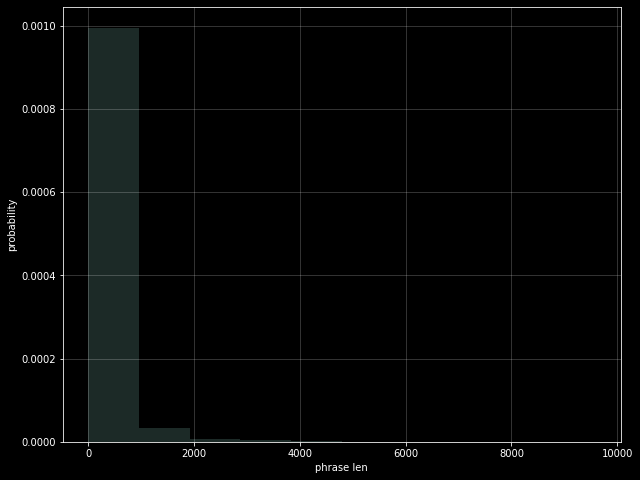

In [125]:
plt.figure(figsize = (10, 8))
plt.hist(new_data['len'], alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [126]:
def normalize(arr):
    norm = arr - arr.min()
    norm = norm / np.abs(norm).max()
    
    return norm

In [127]:
batch_size = 50
epochs = 3

x_train = normalize(X_train)


In [120]:
model_lstm = Sequential()
# model_lstm.add(Embedding(input_dim = 4, output_dim = 256, input_length = max_phrase_len))
# model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(32, batch_input_shape=(batch_size, max_phrase_len, 4)))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(10, activation='softmax'))
#model_lstm.add(Flatten())
model_lstm.summary()

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['categorical_accuracy']
)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (50, 32)                  4736      
_________________________________________________________________
dense_44 (Dense)             (50, 128)                 4224      
_________________________________________________________________
dense_45 (Dense)             (50, 10)                  1290      
Total params: 10,250
Trainable params: 10,250
Non-trainable params: 0
_________________________________________________________________


In [121]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = epochs,
    batch_size = batch_size,
    verbose=1
)

ValueError: Error when checking target: expected dense_45 to have shape (10,) but got array with shape (1,)

In [18]:
score = model_lstm.evaluate(x_test, y_test, verbose=1)
print (score)

ValueError: Error when checking target: expected dense_6 to have shape (1,) but got array with shape (2,)